In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
plt.rcParams["figure.figsize"] = (20,3)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


In [2]:
def translate_time(data: pd.DataFrame, col: str):
    try:
        data['datetime'] = data[col].astype(str).str.replace('T', ' ').str[:-5]
        data['datetime'] = pd.to_datetime(data['datetime'] )
    except Exception as e:
        print(e)
    return data

In [3]:
train_events = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
train_events.shape

(14508, 5)

### Getting the parquet series data

In [4]:
train_series = pd.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')

In [5]:
train_series['timestamp'].min()

'2017-08-04T17:30:00-0400'

In [6]:
train_series['timestamp'].max()

'2019-07-09T09:44:55-0400'

In [7]:
top_five_series = train_events.groupby('series_id')['event'].count().sort_values(ascending=False).head(5)

In [8]:
top_five_series

series_id
78569a801a38    168
f564985ab692    124
fb223ed2278c    106
f56824b503a0    100
cfeb11428dd7     94
Name: event, dtype: int64

### Now get the top 5 series id data from train_series and work on the those data points 

In [9]:
train_series_subset = train_series[train_series['series_id'].isin(top_five_series.index)]
train_series_subset = translate_time(train_series_subset, 'timestamp')
train_series_subset.shape

/tmp/ipykernel_1687/965224494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = data[col].astype(str).str.replace('T', ' ').str[:-5]
/tmp/ipykernel_1687/965224494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = pd.to_datetime(data['datetime'] )


(5061240, 6)

In [10]:
train_events_subset = train_events[train_events['series_id'].isin(top_five_series.index)]
train_events_subset = translate_time(train_events_subset, 'timestamp')
train_events_subset.shape

/tmp/ipykernel_1687/965224494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = data[col].astype(str).str.replace('T', ' ').str[:-5]
/tmp/ipykernel_1687/965224494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = pd.to_datetime(data['datetime'] )


(592, 6)

### EDA

In [11]:
import matplotlib.pyplot as plt

In [12]:
train_events_subset.sample(5)

,series_id,night,event,step,timestamp,datetime
13861,f56824b503a0,14,wakeup,238812.0,2018-10-15T07:26:00-0400,2018-10-15 07:26:00
14215,fb223ed2278c,2,wakeup,32268.0,2018-12-16T08:49:00-0500,2018-12-16 08:49:00
6535,78569a801a38,40,wakeup,NaN,NaN,NaT
13776,f564985ab692,34,onset,NaN,NaN,NaT
13883,f56824b503a0,25,wakeup,NaN,NaN,NaT


### Remove all NULL values for now

In [13]:
mask_non_NULL = (~train_events_subset['step'].isnull()) | (~train_events_subset['timestamp'].isnull())
train_events_subset_nonNULL = train_events_subset[mask_non_NULL]

train_events_subset_nonNULL.shape

(86, 6)

In [14]:
train_events_subset_nonNULL['series_id'].unique()

array(['78569a801a38', 'cfeb11428dd7', 'f564985ab692', 'f56824b503a0',
       'fb223ed2278c'], dtype=object)

In [15]:
train_events_subset_nonNULL[train_events_subset_nonNULL['series_id'] == '78569a801a38']

,series_id,night,event,step,timestamp,datetime
6456,78569a801a38,1,onset,5496.0,2017-08-18T00:23:00-0400,2017-08-18 00:23:00
6457,78569a801a38,1,wakeup,13104.0,2017-08-18T10:57:00-0400,2017-08-18 10:57:00
6458,78569a801a38,2,onset,22488.0,2017-08-18T23:59:00-0400,2017-08-18 23:59:00
6459,78569a801a38,2,wakeup,29244.0,2017-08-19T09:22:00-0400,2017-08-19 09:22:00
6460,78569a801a38,3,onset,42192.0,2017-08-20T03:21:00-0400,2017-08-20 03:21:00
6461,78569a801a38,3,wakeup,47016.0,2017-08-20T10:03:00-0400,2017-08-20 10:03:00
6462,78569a801a38,4,onset,57924.0,2017-08-21T01:12:00-0400,2017-08-21 01:12:00
6463,78569a801a38,4,wakeup,64296.0,2017-08-21T10:03:00-0400,2017-08-21 10:03:00
6464,78569a801a38,5,onset,74364.0,2017-08-22T00:02:00-0400,2017-08-22 00:02:00
6465,78569a801a38,5,wakeup,81372.0,2017-08-22T09:46:00-0400,2017-08-22 09:46:00


In [16]:
sleep_duration = train_events_subset_nonNULL.groupby([
    train_events_subset_nonNULL['series_id'], 
    train_events_subset_nonNULL['night']])['datetime'].agg(['min', 'max']).reset_index()

In [17]:
sleep_duration = sleep_duration.rename(columns={'min': 'onset', 'max': 'wakeup'})
sleep_duration.head(6)

,series_id,night,onset,wakeup
0,78569a801a38,1,2017-08-18 00:23:00,2017-08-18 10:57:00
1,78569a801a38,2,2017-08-18 23:59:00,2017-08-19 09:22:00
2,78569a801a38,3,2017-08-20 03:21:00,2017-08-20 10:03:00
3,78569a801a38,4,2017-08-21 01:12:00,2017-08-21 10:03:00
4,78569a801a38,5,2017-08-22 00:02:00,2017-08-22 09:46:00
5,78569a801a38,6,2017-08-23 00:55:00,2017-08-23 08:02:00


In [18]:
sleep_duration['duration'] = ((sleep_duration['wakeup'] - sleep_duration['onset']).dt.seconds / 3600).round(0)
sleep_duration.head(6)

,series_id,night,onset,wakeup,duration
0,78569a801a38,1,2017-08-18 00:23:00,2017-08-18 10:57:00,11.0
1,78569a801a38,2,2017-08-18 23:59:00,2017-08-19 09:22:00,9.0
2,78569a801a38,3,2017-08-20 03:21:00,2017-08-20 10:03:00,7.0
3,78569a801a38,4,2017-08-21 01:12:00,2017-08-21 10:03:00,9.0
4,78569a801a38,5,2017-08-22 00:02:00,2017-08-22 09:46:00,10.0
5,78569a801a38,6,2017-08-23 00:55:00,2017-08-23 08:02:00,7.0


Text(0, 0.5, 'Sleep duration in hours')

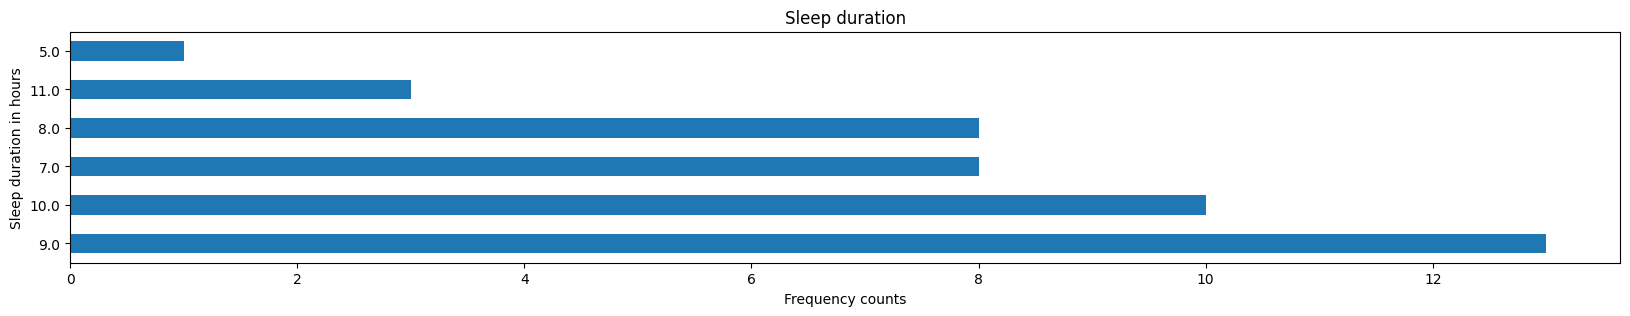

In [19]:
sleep_duration['duration'].value_counts().plot(kind='barh')

plt.title('Sleep duration')
plt.xlabel('Frequency counts')
plt.ylabel('Sleep duration in hours')

### Merge both the datsets based on the user_id

In [20]:
train_series_subset.head()

,series_id,step,timestamp,anglez,enmo,datetime
57604860,78569a801a38,0,2017-08-17T16:45:00-0400,-0.709000,0.0521,2017-08-17 16:45:00
57604861,78569a801a38,1,2017-08-17T16:45:05-0400,26.159300,0.0415,2017-08-17 16:45:05
57604862,78569a801a38,2,2017-08-17T16:45:10-0400,-19.055300,0.0312,2017-08-17 16:45:10
57604863,78569a801a38,3,2017-08-17T16:45:15-0400,-56.735001,0.0486,2017-08-17 16:45:15
57604864,78569a801a38,4,2017-08-17T16:45:20-0400,-59.033001,0.0350,2017-08-17 16:45:20


In [21]:
train_events_subset_nonNULL.head()

,series_id,night,event,step,timestamp,datetime
6456,78569a801a38,1,onset,5496.0,2017-08-18T00:23:00-0400,2017-08-18 00:23:00
6457,78569a801a38,1,wakeup,13104.0,2017-08-18T10:57:00-0400,2017-08-18 10:57:00
6458,78569a801a38,2,onset,22488.0,2017-08-18T23:59:00-0400,2017-08-18 23:59:00
6459,78569a801a38,2,wakeup,29244.0,2017-08-19T09:22:00-0400,2017-08-19 09:22:00
6460,78569a801a38,3,onset,42192.0,2017-08-20T03:21:00-0400,2017-08-20 03:21:00


In [22]:
train_data_events = pd.merge(train_series_subset, train_events_subset_nonNULL, on=['timestamp', 'datetime'], how='left')
train_data_events.head(5)

,series_id_x,step_x,timestamp,anglez,enmo,datetime,series_id_y,night,event,step_y
0,78569a801a38,0,2017-08-17T16:45:00-0400,-0.709000,0.0521,2017-08-17 16:45:00,NaN,NaN,NaN,NaN
1,78569a801a38,1,2017-08-17T16:45:05-0400,26.159300,0.0415,2017-08-17 16:45:05,NaN,NaN,NaN,NaN
2,78569a801a38,2,2017-08-17T16:45:10-0400,-19.055300,0.0312,2017-08-17 16:45:10,NaN,NaN,NaN,NaN
3,78569a801a38,3,2017-08-17T16:45:15-0400,-56.735001,0.0486,2017-08-17 16:45:15,NaN,NaN,NaN,NaN
4,78569a801a38,4,2017-08-17T16:45:20-0400,-59.033001,0.0350,2017-08-17 16:45:20,NaN,NaN,NaN,NaN


In [23]:
train_data_events = train_data_events.drop(['step_y', 'series_id_y'], axis=1)
train_data_events = train_data_events.rename(columns = {'series_id_x': 'series_id', 'step_x' : 'step'})

In [24]:
train_data_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5061240 entries, 0 to 5061239
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   series_id  object        
 1   step       uint32        
 2   timestamp  object        
 3   anglez     float32       
 4   enmo       float32       
 5   datetime   datetime64[ns]
 6   night      float64       
 7   event      object        
dtypes: datetime64[ns](1), float32(2), float64(1), object(3), uint32(1)
memory usage: 251.0+ MB


In [25]:
train_data_events[5496:13104]

,series_id,step,timestamp,anglez,enmo,datetime,night,event
5496,78569a801a38,5496,2017-08-18T00:23:00-0400,-25.705500,0.0779,2017-08-18 00:23:00,1.0,onset
5497,78569a801a38,5497,2017-08-18T00:23:05-0400,-24.005400,0.0132,2017-08-18 00:23:05,NaN,NaN
5498,78569a801a38,5498,2017-08-18T00:23:10-0400,-24.335100,0.0143,2017-08-18 00:23:10,NaN,NaN
5499,78569a801a38,5499,2017-08-18T00:23:15-0400,-24.816200,0.0142,2017-08-18 00:23:15,NaN,NaN
5500,78569a801a38,5500,2017-08-18T00:23:20-0400,-24.808500,0.0215,2017-08-18 00:23:20,NaN,NaN
...,...,...,...,...,...,...,...,...
13099,78569a801a38,13099,2017-08-18T10:56:35-0400,-53.711800,0.0037,2017-08-18 10:56:35,NaN,NaN
13100,78569a801a38,13100,2017-08-18T10:56:40-0400,-53.711800,0.0037,2017-08-18 10:56:40,NaN,NaN
13101,78569a801a38,13101,2017-08-18T10:56:45-0400,-53.692799,0.0033,2017-08-18 10:56:45,NaN,NaN
13102,78569a801a38,13102,2017-08-18T10:56:50-0400,-53.316700,0.0012,2017-08-18 10:56:50,NaN,NaN


In [26]:
onset_wakeup_events = train_data_events[~train_data_events['event'].isnull()]
onset_wakeup_events = onset_wakeup_events.reset_index()

In [27]:
onset_wakeup_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      98 non-null     int64         
 1   series_id  98 non-null     object        
 2   step       98 non-null     uint32        
 3   timestamp  98 non-null     object        
 4   anglez     98 non-null     float32       
 5   enmo       98 non-null     float32       
 6   datetime   98 non-null     datetime64[ns]
 7   night      98 non-null     float64       
 8   event      98 non-null     object        
dtypes: datetime64[ns](1), float32(2), float64(1), int64(1), object(3), uint32(1)
memory usage: 5.9+ KB


### USEFUL  METHODS FOR DATA PROCESSING

In [28]:
def attach_nightID_and_sleep_state(
    user_id: str,
    train_series: pd.DataFrame, 
    wakeup_onset: pd.DataFrame,
    init_last_index: int):
    
    train_series = train_series[train_series['series_id'] == user_id]
    train_series = train_series.reset_index()
    wakeup_onset = wakeup_onset[wakeup_onset['series_id'] == user_id]
    wakeup_onset = wakeup_onset.reset_index()
    
    train_series.loc[0: init_last_index, 'night'] = 1.0
    train_series.loc[0: init_last_index, 'event'] = 'awake'
    
    if user_id == 'f564985ab692':
        wakeup_onset = wakeup_onset.drop([1, 3])
    
    for idx in np.arange(0, len(wakeup_onset), 2):
        step_sleep = wakeup_onset.iloc[idx]['step']
        step_wakeup = int(wakeup_onset.iloc[idx + 1]['step'])
        night = wakeup_onset.iloc[idx]['night']
        # print(step_sleep, step_wakeup, night)

        train_series.loc[step_sleep+1: step_wakeup, 'night'] = night
        train_series.loc[step_sleep+1: step_wakeup, 'event'] = 'sleep'

    # print("======")
    for idx in np.arange(1, len(wakeup_onset) -1, 2):
        # print(onset_wakeup_events.iloc[idx])
        night_value = wakeup_onset.iloc[idx]['night']
        step_sleep = wakeup_onset.iloc[idx]['step']
        step_wakeup = int(wakeup_onset.iloc[idx + 1]['step'])
        night = wakeup_onset.iloc[idx + 1]['night']
        # print(step_sleep, step_wakeup, night)

        train_series.loc[step_sleep+1: step_wakeup, 'night'] = night
        train_series.loc[step_sleep+1: step_wakeup, 'event'] = 'awake'
    return train_series, wakeup_onset

### Fix NULLs in the following IDs 
A : 78569a801a38
B : f564985ab692
C : fb223ed2278c
D : f56824b503a0
E : cfeb11428dd7

## ID : 78569a801a38

In [29]:
# Set night from 0 to 5495 for ID A 

train_data_events_A, wakeup_onset_A = attach_nightID_and_sleep_state(
    train_series=train_data_events.copy(),
    wakeup_onset=onset_wakeup_events.copy(),
    user_id="78569a801a38",
    init_last_index=5496
)

wakeup_onset_A.head(10)

,level_0,index,series_id,step,timestamp,anglez,enmo,datetime,night,event
0,0,5496,78569a801a38,5496,2017-08-18T00:23:00-0400,-25.705500,0.0779,2017-08-18 00:23:00,1.0,onset
1,1,13104,78569a801a38,13104,2017-08-18T10:57:00-0400,-53.118599,0.0000,2017-08-18 10:57:00,1.0,wakeup
2,2,22488,78569a801a38,22488,2017-08-18T23:59:00-0400,52.196602,0.0000,2017-08-18 23:59:00,2.0,onset
3,3,29244,78569a801a38,29244,2017-08-19T09:22:00-0400,20.395500,0.0000,2017-08-19 09:22:00,2.0,wakeup
4,4,42192,78569a801a38,42192,2017-08-20T03:21:00-0400,-53.506802,0.0000,2017-08-20 03:21:00,3.0,onset
5,5,47016,78569a801a38,47016,2017-08-20T10:03:00-0400,58.840099,0.0000,2017-08-20 10:03:00,3.0,wakeup
6,6,57924,78569a801a38,57924,2017-08-21T01:12:00-0400,-81.068298,0.0099,2017-08-21 01:12:00,4.0,onset
7,7,64296,78569a801a38,64296,2017-08-21T10:03:00-0400,43.470901,0.0000,2017-08-21 10:03:00,4.0,wakeup
8,8,74364,78569a801a38,74364,2017-08-22T00:02:00-0400,-73.443901,0.0000,2017-08-22 00:02:00,5.0,onset
9,9,81372,78569a801a38,81372,2017-08-22T09:46:00-0400,-53.513500,0.0000,2017-08-22 09:46:00,5.0,wakeup


(17280, 9)


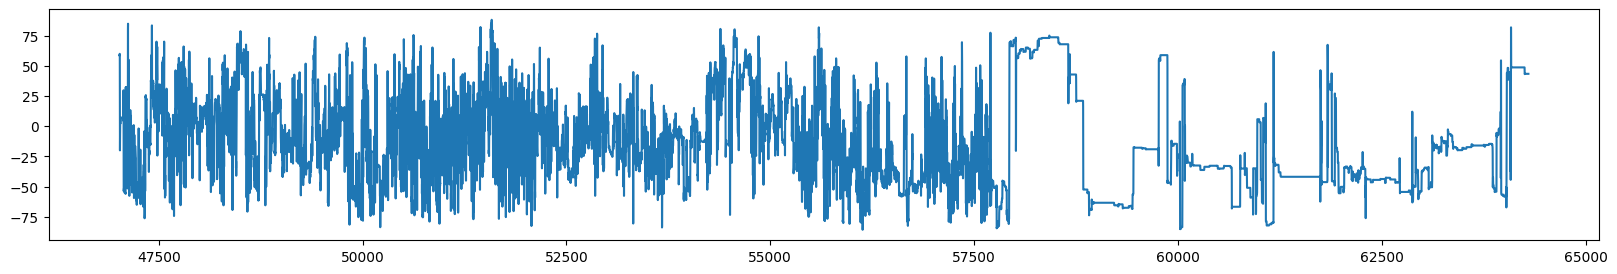

In [31]:
# Plot for 
anglez_for_series_A = train_data_events_A[train_data_events_A['night'] == 4.0]
print(anglez_for_series_A.shape)
plt.plot(anglez_for_series_A['step'], anglez_for_series_A['anglez'])

(17280, 9)


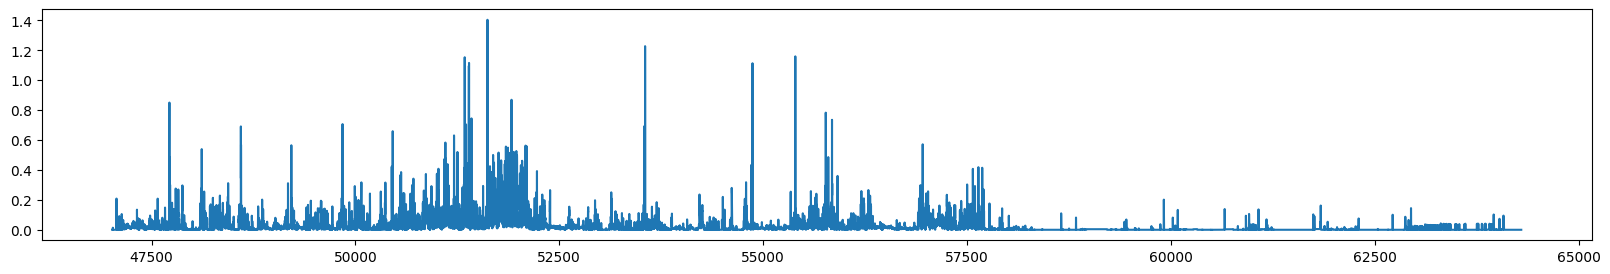

In [32]:
# Plot for 
enmo_for_series_A = train_data_events_A[train_data_events_A['night'] == 4.0]
print(enmo_for_series_A.shape)
plt.plot(enmo_for_series_A['step'], enmo_for_series_A['enmo'])

### ID : f564985ab692

In [33]:
# Set night from 0 to 5495 for ID A 

train_data_events_B, wakeup_onset_B = attach_nightID_and_sleep_state(
    train_series=train_data_events.copy(),
    wakeup_onset=onset_wakeup_events.copy(),
    user_id="f564985ab692",
    init_last_index=5640
)

wakeup_onset_B.head(10)

,level_0,index,series_id,step,timestamp,anglez,enmo,datetime,night,event
0,42,2249340,f564985ab692,5640,2018-12-22T22:35:00-0500,-45.807598,0.0011,2018-12-22 22:35:00,1.0,onset
2,44,2256972,f564985ab692,13272,2018-12-23T09:11:00-0500,-7.875400,0.0000,2018-12-23 09:11:00,1.0,wakeup
4,46,2266740,f564985ab692,23040,2018-12-23T22:45:00-0500,4.468400,0.0001,2018-12-23 22:45:00,2.0,onset
5,47,2271492,f564985ab692,27792,2018-12-24T05:21:00-0500,-31.685301,0.0000,2018-12-24 05:21:00,2.0,wakeup
6,48,2387784,f564985ab692,144084,2018-12-30T22:52:00-0500,-47.088600,0.0096,2018-12-30 22:52:00,9.0,onset
7,49,2394900,f564985ab692,151200,2018-12-31T08:45:00-0500,-65.067902,0.0000,2018-12-31 08:45:00,9.0,wakeup
8,50,2475804,f564985ab692,232104,2019-01-05T01:07:00-0500,41.042702,0.1199,2019-01-05 01:07:00,14.0,onset
9,51,2482380,f564985ab692,238680,2019-01-05T10:15:00-0500,31.995501,0.0000,2019-01-05 10:15:00,14.0,wakeup
10,52,2578920,f564985ab692,335220,2019-01-11T00:20:00-0500,-38.461399,0.0048,2019-01-11 00:20:00,20.0,onset
11,53,2586096,f564985ab692,342396,2019-01-11T10:18:00-0500,43.813099,0.0000,2019-01-11 10:18:00,20.0,wakeup


(14520, 9)


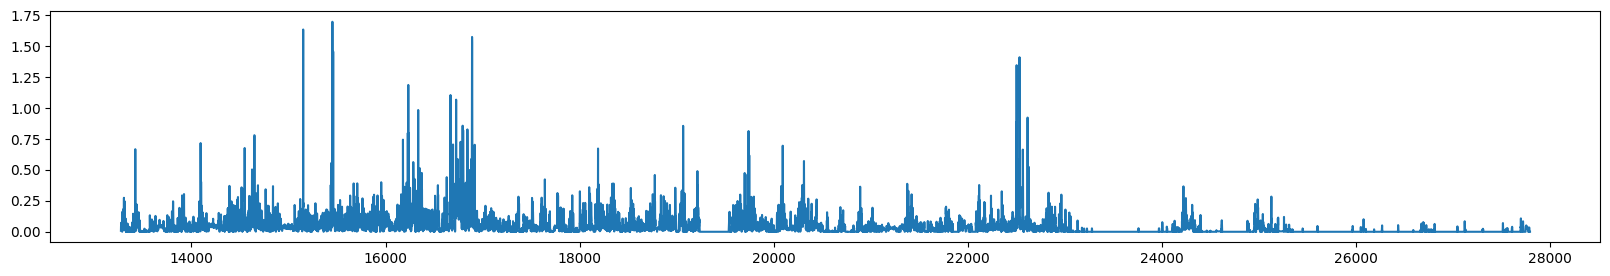

In [34]:
# Plot for 
enmo_for_series_B = train_data_events_B[(train_data_events_B['night'] == 2.0)]
print(enmo_for_series_B.shape)
plt.plot(enmo_for_series_B['step'], enmo_for_series_B['enmo'])

(14520, 9)


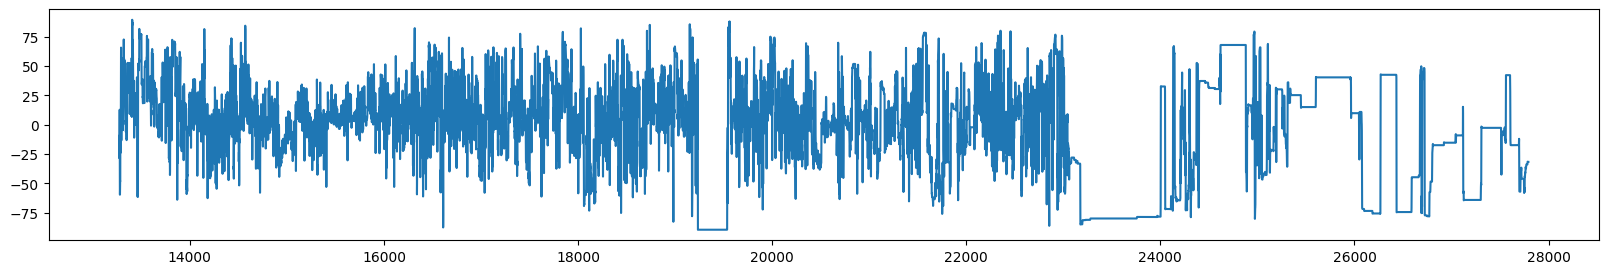

In [35]:
# Plot for 
anglez_for_series = train_data_events_B[train_data_events_B['night'] == 2.0]
print(anglez_for_series.shape)
plt.plot(anglez_for_series['step'], anglez_for_series['anglez'])

### ID : fb223ed2278c

In [36]:
# Set night from 0 to 5495 for ID A 

train_data_events_C, wakeup_onset_C = attach_nightID_and_sleep_state(
    train_series=train_data_events.copy(),
    wakeup_onset=onset_wakeup_events.copy(),
    user_id="fb223ed2278c",
    init_last_index=7536
)

wakeup_onset_C.head()

,level_0,index,series_id,step,timestamp,anglez,enmo,datetime,night,event
0,78,4150416,fb223ed2278c,7536,2018-12-14T22:28:00-0500,13.368200,0.0065,2018-12-14 22:28:00,1.0,onset
1,79,4157496,fb223ed2278c,14616,2018-12-15T08:18:00-0500,67.870300,0.0000,2018-12-15 08:18:00,1.0,wakeup
2,80,4168296,fb223ed2278c,25416,2018-12-15T23:18:00-0500,-82.897202,0.0000,2018-12-15 23:18:00,2.0,onset
3,81,4175148,fb223ed2278c,32268,2018-12-16T08:49:00-0500,64.695999,0.0000,2018-12-16 08:49:00,2.0,wakeup
4,82,4201380,fb223ed2278c,58500,2018-12-17T21:15:00-0500,80.147301,0.0000,2018-12-17 21:15:00,4.0,onset


(123408, 9)


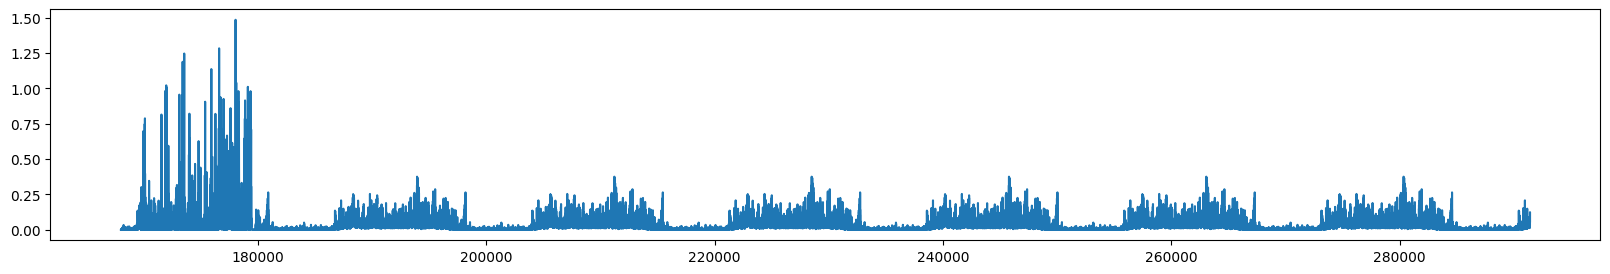

In [37]:
# Plot for 
enmo_for_series_C = train_data_events_C[(train_data_events_C['night'] == 9.0)]
print(enmo_for_series_C.shape)
plt.plot(enmo_for_series_C['step'], enmo_for_series_C['enmo'])

(123408, 9)


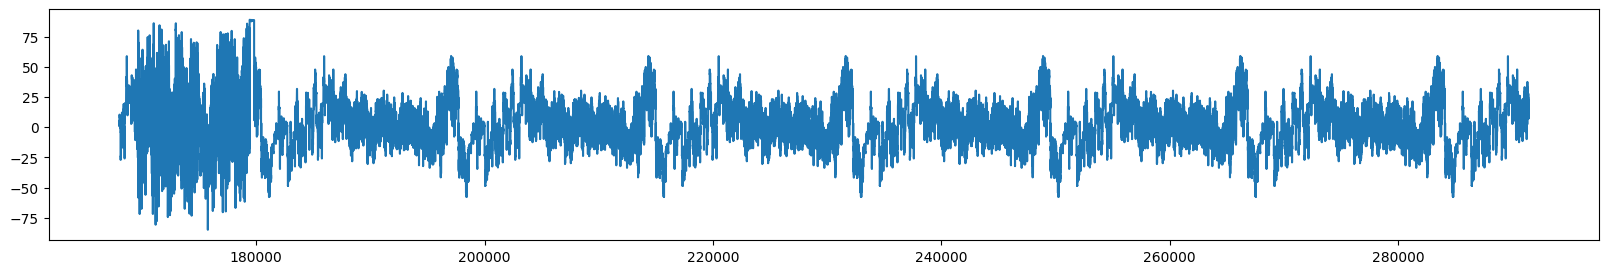

In [38]:
# Plot for 
anglez_for_series_C = train_data_events_C[(train_data_events_C['night'] == 9.0)]
print(anglez_for_series_C.shape)
plt.plot(anglez_for_series_C['step'], anglez_for_series_C['anglez'])

### ID : f56824b503a0

In [39]:
# Set night from 0 to 5495 for ID D

train_data_events_D, wakeup_onset_D = attach_nightID_and_sleep_state(
    train_series=train_data_events.copy(),
    wakeup_onset=onset_wakeup_events.copy(),
    user_id="f56824b503a0",
    init_last_index=24228
)

wakeup_onset_D.head(10)

,level_0,index,series_id,step,timestamp,anglez,enmo,datetime,night,event
0,54,3320748,f56824b503a0,24228,2018-10-02T21:24:00-0400,15.170200,0.0585,2018-10-02 21:24:00,2.0,onset
1,55,3326568,f56824b503a0,30048,2018-10-03T05:29:00-0400,-22.057501,0.0598,2018-10-03 05:29:00,2.0,wakeup
2,56,3338136,f56824b503a0,41616,2018-10-03T21:33:00-0400,-75.919998,0.0000,2018-10-03 21:33:00,3.0,onset
3,57,3343536,f56824b503a0,47016,2018-10-04T05:03:00-0400,59.782902,0.0027,2018-10-04 05:03:00,3.0,wakeup
4,58,3355104,f56824b503a0,58584,2018-10-04T21:07:00-0400,41.974499,0.1042,2018-10-04 21:07:00,4.0,onset
5,59,3360996,f56824b503a0,64476,2018-10-05T05:18:00-0400,-3.756600,0.0114,2018-10-05 05:18:00,4.0,wakeup
6,60,3373104,f56824b503a0,76584,2018-10-05T22:07:00-0400,-29.108299,0.0055,2018-10-05 22:07:00,5.0,onset
7,61,3378096,f56824b503a0,81576,2018-10-06T05:03:00-0400,-60.408798,0.0016,2018-10-06 05:03:00,5.0,wakeup
8,62,3392592,f56824b503a0,96072,2018-10-07T01:11:00-0400,9.137800,0.0000,2018-10-07 01:11:00,6.0,onset
9,63,3397356,f56824b503a0,100836,2018-10-07T07:48:00-0400,-20.885300,0.0062,2018-10-07 07:48:00,6.0,wakeup


(19260, 9)


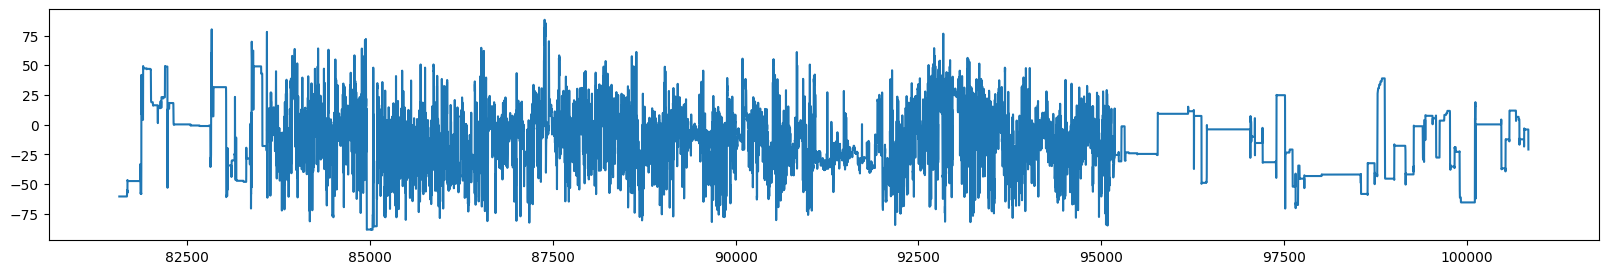

In [40]:
# Plot for 
anglez_for_series_D = train_data_events_D[(train_data_events_D['night'] == 6.0)]
print(anglez_for_series_D.shape)
plt.plot(anglez_for_series_D['step'], anglez_for_series_D['anglez'])

(19260, 9)


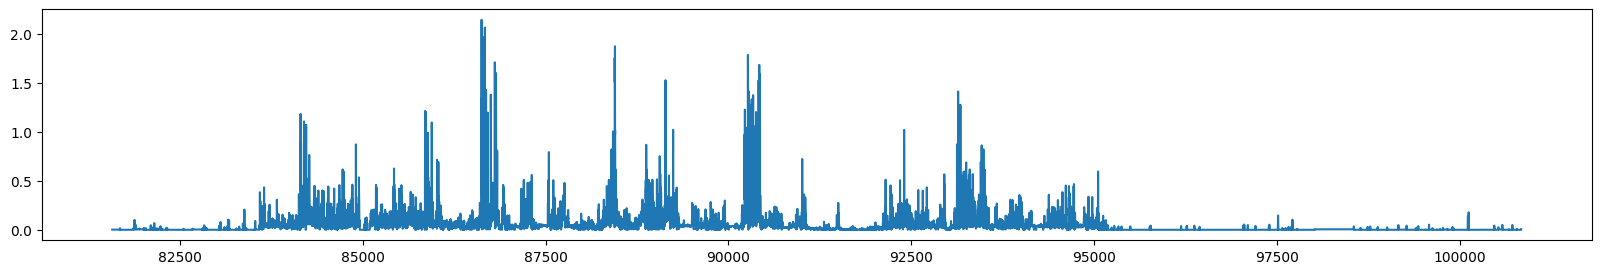

In [41]:
# Plot for 
anglez_for_series_D = train_data_events_D[(train_data_events_D['night'] == 6.0)]
print(anglez_for_series_D.shape)
plt.plot(anglez_for_series_D['step'], anglez_for_series_D['enmo'])

### ID : cfeb11428dd7

In [42]:
# Set night from 0 to 5495 for ID D

train_data_events_E, wakeup_onset_E = attach_nightID_and_sleep_state(
    train_series=train_data_events.copy(),
    wakeup_onset=onset_wakeup_events.copy(),
    user_id="cfeb11428dd7",
    init_last_index=7200
)

wakeup_onset_E

,level_0,index,series_id,step,timestamp,anglez,enmo,datetime,night,event
0,24,1441080,cfeb11428dd7,7200,2018-05-03T22:00:00-0400,-33.179501,0.0039,2018-05-03 22:00:00,1.0,onset
1,25,1447776,cfeb11428dd7,13896,2018-05-04T07:18:00-0400,-53.400002,0.0000,2018-05-04 07:18:00,1.0,wakeup
2,26,1461552,cfeb11428dd7,27672,2018-05-05T02:26:00-0400,43.014801,0.0000,2018-05-05 02:26:00,2.0,onset
3,27,1465140,cfeb11428dd7,31260,2018-05-05T07:25:00-0400,23.414000,0.0000,2018-05-05 07:25:00,2.0,wakeup
4,28,1475628,cfeb11428dd7,41748,2018-05-05T21:59:00-0400,-25.011499,0.0000,2018-05-05 21:59:00,3.0,onset
5,29,1482864,cfeb11428dd7,48984,2018-05-06T08:02:00-0400,-11.958600,0.0125,2018-05-06 08:02:00,3.0,wakeup
6,30,1493676,cfeb11428dd7,59796,2018-05-06T23:03:00-0400,45.552399,0.0017,2018-05-06 23:03:00,4.0,onset
7,31,1499904,cfeb11428dd7,66024,2018-05-07T07:42:00-0400,84.749001,0.0000,2018-05-07 07:42:00,4.0,wakeup
8,32,1648884,cfeb11428dd7,215004,2018-05-15T22:37:00-0400,53.017101,0.0022,2018-05-15 22:37:00,13.0,onset
9,33,1655100,cfeb11428dd7,221220,2018-05-16T07:15:00-0400,-46.880299,0.0001,2018-05-16 07:15:00,13.0,wakeup


(17724, 9)


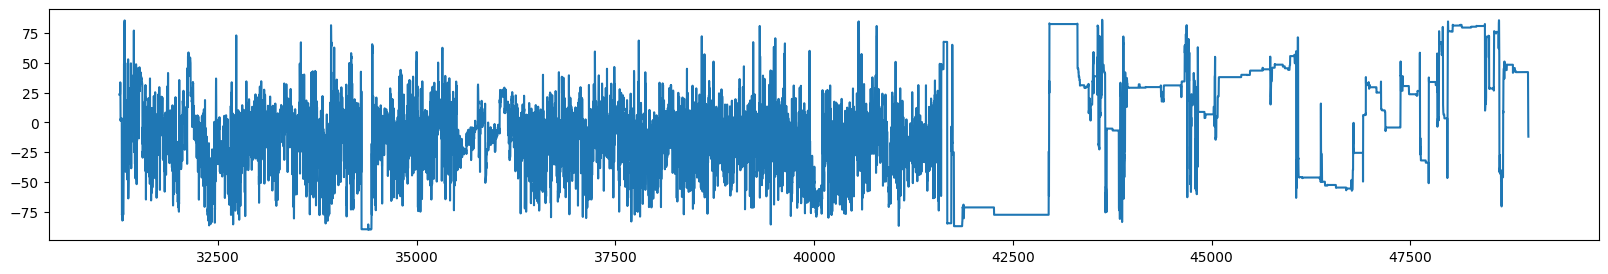

In [43]:
# Plot for 
anglez_for_series_E = train_data_events_E[(train_data_events_E['night'] == 3.0)]
print(anglez_for_series_E.shape)
plt.plot(anglez_for_series_E['step'], anglez_for_series_E['anglez'])

(17724, 9)


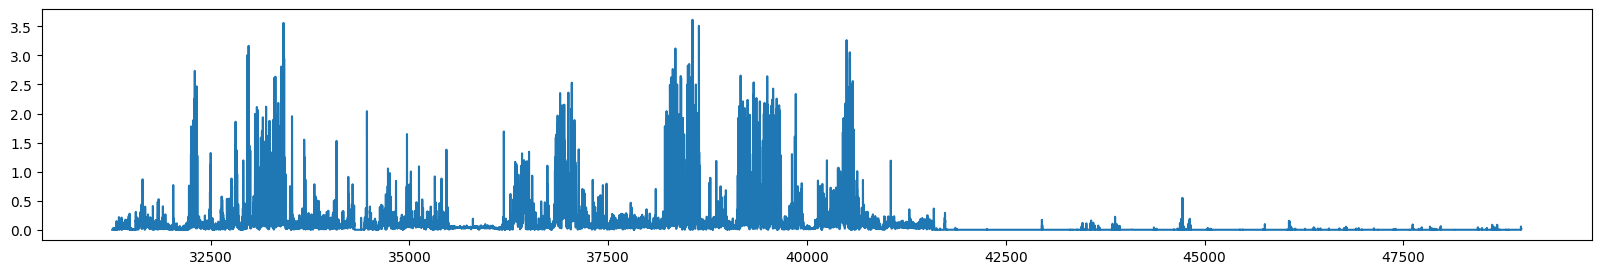

In [44]:
# Plot for 
enmo_for_series_E = train_data_events_E[(train_data_events_E['night'] == 3.0)]
print(enmo_for_series_E.shape)
plt.plot(anglez_for_series_E['step'], anglez_for_series_E['enmo'])